In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


EDA 는 생략 입니다. 

In [2]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

In [3]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [4]:
for df in [df_train, df_test]:
	df['sale_yr'] = pd.to_numeric(df.date.str.slice(0, 4))
	df['sale_month'] = pd.to_numeric(df.date.str.slice(4, 6))
	df['sale_day'] = pd.to_numeric(df.date.str.slice(6, 8))
	df.drop(['id', 'date'], axis=1, inplace=True)

In [5]:
df_train = df_train.astype('float32')
df_test = df_test.astype('float32')

In [6]:
for df in [df_train, df_test]:
	#재건축 여부
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x < 0 else 1)
	
    # 용적률 주거 공간 / 대지 면적
    df['far1'] = df['sqft_living'] / df['sqft_lot']

	# 1층의 크기
	# sqft_living = sqft_above + sqft_basement
    #df['1st_living'] = df['sqft_above'] / (df['floors'] )

    #%% 건폐률
    #df['far2'] = df['1st_living'] / df['sqft_lot']

	# 마당의 크기
	# 대지 면적에서 1층의 크기를 빼서 마당 크기로 간주
    #df['yard'] = df['sqft_lot'] - df['1st_living']
    #df['is_yard'] = df['yard'].apply(lambda x: 0 if x <= 0 else 1)

    # 지하가 있냐 없냐?
    #df['is_basement'] = df['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)
    # 다락이 있냐 없냐?
    #df['is_top'] = df['floors'].apply(lambda x: 0 if int(x) == x else 1)

    # Full Bath 수
    df['full_bath'] = (df['bathrooms'] / 1) 
    df['full_bath'] = df['full_bath'].astype('int')

    df['75bath'] = (df['bathrooms'] - df['full_bath']) / 0.75
    df['75bath'] = df['75bath'].astype('int')

    df['50bath'] = (df['bathrooms'] - df['full_bath'] - df['75bath']*0.75) / 0.5
    df['50bath'] = df['50bath'].astype('int')

    df['25bath'] = (df['bathrooms'] - df['full_bath'] - df['75bath']*0.75 - df['50bath']*0.5) / 0.25
    df['25bath'] = df['25bath'].astype('int')

    df['total_bath'] = df['full_bath'] + df['75bath'] + df['50bath'] + df['25bath']

    # 층당 화장실 개수
    df['bath_per_floors'] = df['total_bath'] / df['floors']

    # 방당 화장실 개수
    df['bath_per_rooms'] = df['total_bath'] / df['bedrooms']

In [7]:
df_train['per_price'] = df_train['price'] / df_train['sqft_living']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

In [8]:
encoder = LabelEncoder()
for df in [df_train, df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_living']
    del df['mean']
    df['zipcode'] = encoder.fit_transform(df['zipcode'])
    df.drop([
        'sale_day', 'full_bath', '75bath', 
        '50bath', '25bath', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

df_train.drop(['per_price'], axis=1, inplace=True)

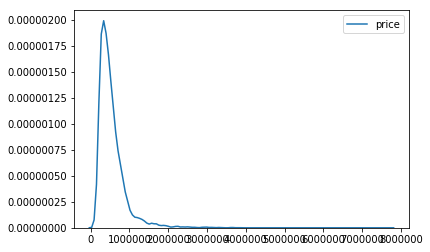

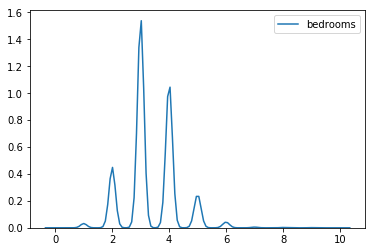

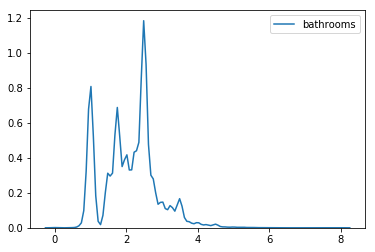

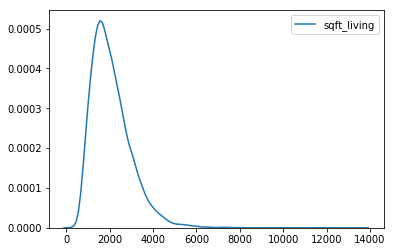

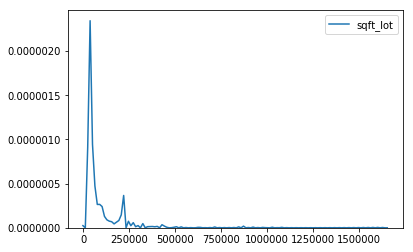

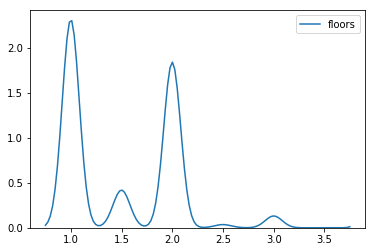

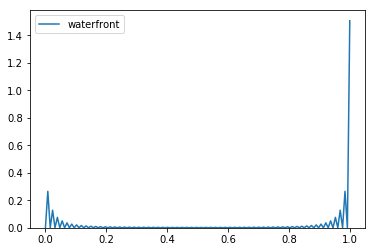

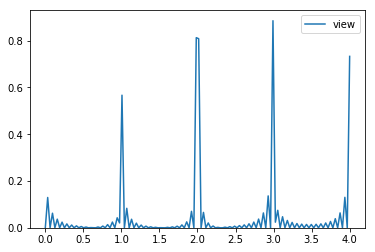

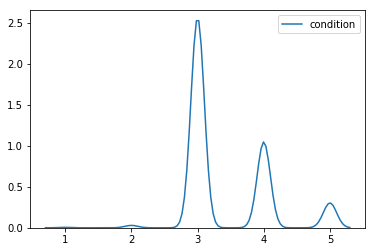

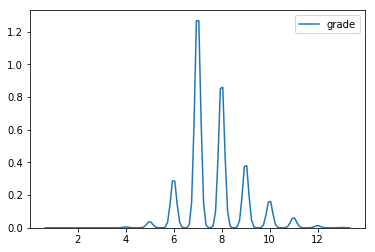

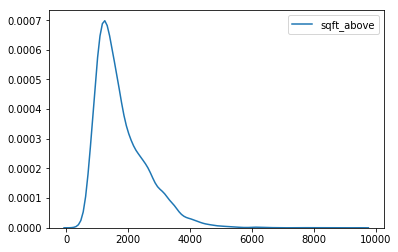

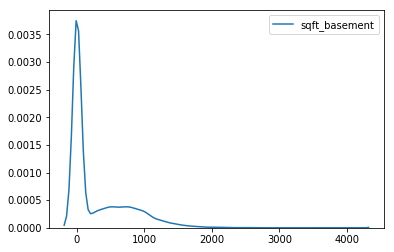

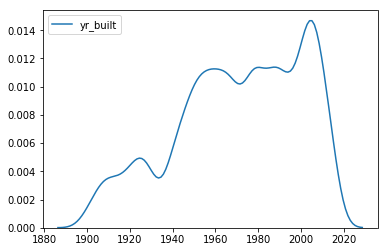

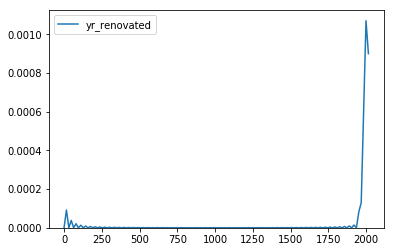

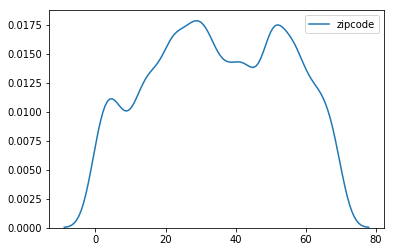

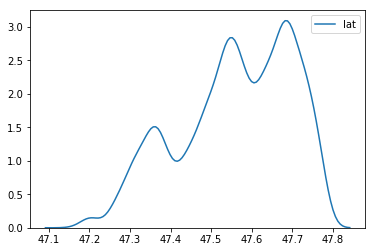

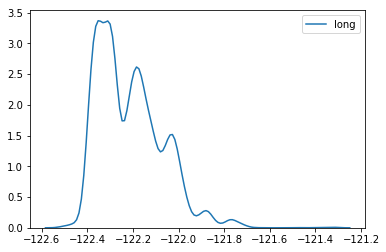

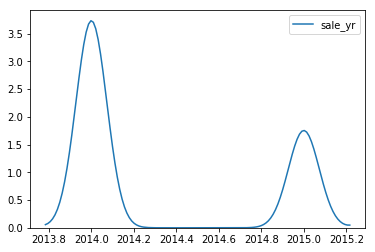

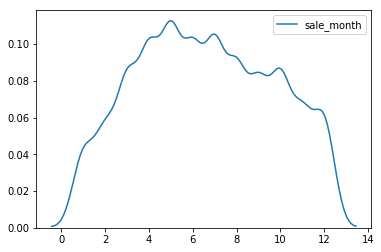

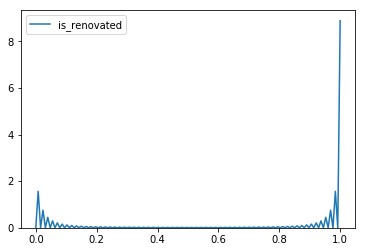

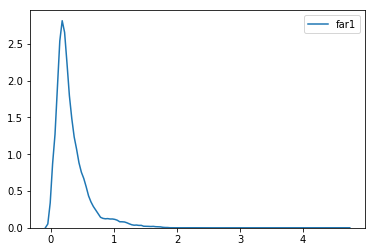

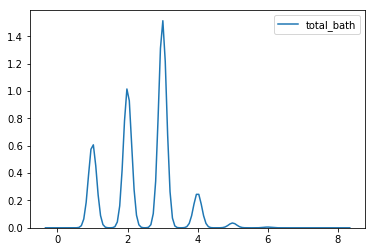

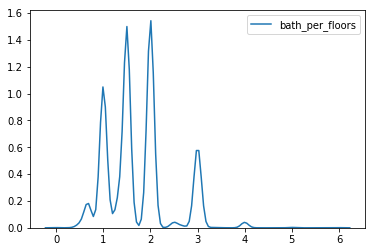

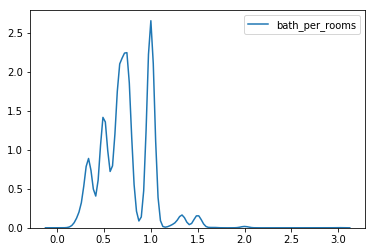

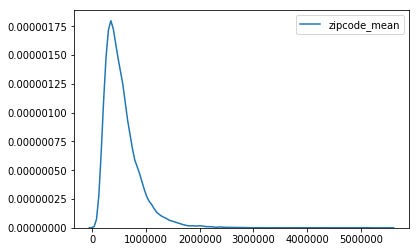

In [9]:
for c in df_train.columns:
	sns.kdeplot(df_train[c])
	plt.show()

In [10]:
skew_columns = [
    'sqft_living', 
    'sqft_lot', 
    'sqft_above',
    'sqft_basement',
    'far1',
    'zipcode_mean']

In [11]:
for df in [df_train, df_test]:
	for c in skew_columns:
		df[c] = np.log1p(df[c])

df_train['price'] = np.log1p(df_train['price'])

In [12]:
df_train_target = df_train['price']
df_train_features = df_train.drop(['price'], axis=1)

아래 코드는 파이썬 머신러닝 완벽가이드에서 가져옴.

In [13]:
def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring='neg_mean_squared_error')

    grid_model.fit(df_train_features, df_train_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [14]:
xgb_params ={
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bytree': [0.5],
    'silent': [True],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'n_estimators':[1000],
    'refit' : [True]
}

xgb_model = XGBRegressor()
xgb_estimator = print_best_params(xgb_model, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 0.1599, 최적 alpha:{'colsample_bytree': 0.5, 'gpu_id': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'predictor': 'gpu_predictor', 'refit': True, 'silent': True, 'subsample': 0.9, 'tree_method': 'gpu_hist'}


In [15]:
lgb_params = {
    'objective':['regression'],
    'num_leave' : [1],
    'learning_rate' : [0.05],
    'n_estimators':[1000],
    'max_bin' : [80],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'refit':[True]
}

lgb_model = LGBMRegressor()
lgb_estimator = print_best_params(lgb_model, lgb_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 0.1626, 최적 alpha:{'gpu_id': 0, 'learning_rate': 0.05, 'max_bin': 80, 'n_estimators': 1000, 'num_leave': 1, 'objective': 'regression', 'predictor': 'gpu_predictor', 'refit': True, 'tree_method': 'gpu_hist'}


In [16]:
xgb_preds = xgb_estimator.predict(df_test)
lgb_preds = lgb_estimator.predict(df_test)
preds = 0.5* xgb_preds + 0.5*lgb_preds

In [17]:
submission=pd.read_csv('../input/sample_submission.csv')
submission['price']=np.exp(preds)
submission.to_csv('xgb_lgb_submission.csv',index=False)